In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn
from torch import optim
import torch.nn.functional as F #it has relu, softmax etc
from torchsummary import summary   #can get summary of model

In [ ]:
transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize(( 0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
dataiter=iter(trainloader)
images, labels=next(dataiter)
print('Maximum value in image array: ',int(images[0].max()),'\n Minimum value in image array: ',int(images[0].min()))

Maximum value in image array:  1 
 Minimum value in image array:  0


* The images are tensors between 0 and 1

In [ ]:
def unnormalize(image):
  image=image.numpy()
  image = np.transpose(image,(1,2,0))
  image = image*0.5 + 0.5 #unormalize the image
  return image

In [ ]:
dataiter=iter(trainloader)
images, labels=next(dataiter)

In [ ]:
images.shape

torch.Size([32, 3, 32, 32])

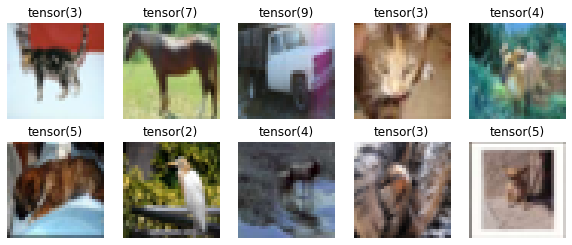

In [ ]:
w=32
h=32
fig=plt.figure(figsize=(10, 4))
for i in range(1, 11):
    ax=fig.add_subplot(2, 5, i)
    ax.grid('off')
    ax.axis('off')
    ax.imshow(unnormalize(images[i]))
    ax.set_title(labels[i])

In [ ]:
def make_model():
    model = Sequential()
    model.add(Conv2D(filters=16,input_shape=(32,32,3), kernel_size=(3,3), strides=(1,1), padding = 'same'))
    model.add(LeakyReLU(0.1))

    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding = 'same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.5))

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
    model.add(LeakyReLU(0.1))

    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding = 'same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(units=256))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=10))
    
    model.add(Activation("softmax"))
    
    return model

In [ ]:
class Model(nn.Module):

    def __init__(self, n_classes):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3,padding=1)
        #self.conv1.weight = torch.nn.Parameter(myweights)    #we can initialize the weights of layer to myweights, passed in __init__, look udacity CNN folder
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)# maxpool layer pool with kernel_size=2, stride=2
        self.conv3 = nn.Conv2d(32, 32, 3, padding =1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding =1)
        self.fc1 = nn.Linear(64*8*8, 256)# 32*4 input size to account for the downsampled image size after pooling num_classes outputs (for n_classes of image data)
        self.fc2 = nn.Linear(256,n_classes)
        self.dropout = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.25)
    def forward(self, x): # define the feedforward behavior
        x = F.relu(self.conv1(x))
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        x = F.relu(self.conv3(x))        # one conv/relu + pool layers
        x = self.dropout2(self.pool(F.relu(self.conv4(x))))
        x = x.view(x.size(0), -1)        # prep for linear layer by flattening the feature maps into feature vectors
        x = self.dropout2(F.relu(self.fc1(x)))         # linear layer 
        x = F.relu(self.fc2(x))
        x = F.softmax(x)
        # final output
        return x
        

In [ ]:
model = Model(10)
print(model)

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.25, inplace=False)
)


In [ ]:
summary(model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
            Conv2d-2           [-1, 32, 32, 32]           4,640
         MaxPool2d-3           [-1, 32, 16, 16]               0
           Dropout-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]           9,248
            Conv2d-6           [-1, 64, 16, 16]          18,496
         MaxPool2d-7             [-1, 64, 8, 8]               0
           Dropout-8             [-1, 64, 8, 8]               0
            Linear-9                  [-1, 256]       1,048,832
          Dropout-10                  [-1, 256]               0
           Linear-11                   [-1, 10]           2,570
Total params: 1,084,234
Trainable params: 1,084,234
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

In [ ]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss() 
optimizer = optim.Adamax(model.parameters(), lr=0.01)
optimizer.zero_grad()   
steps=0
epochs=100
for e in range(epochs):
    running_loss = 0
    steps=0
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten MNIST images into a 784 long vector
        optimizer.zero_grad()
        images=images.to('cuda')
        labels=labels.to('cuda')
        output = model.forward(images)    #forward pass
        loss = criterion(output, labels)  #loss calculation
        loss.backward()                   #backward pass
        optimizer.step()
        
        running_loss += loss.item()  #The item() method extracts the loss’s value as a Python float.
        # print statistics
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (e + 1, steps + 1, running_loss / 2000))
            running_loss = 0.0
        

with torch.no_grad():
    logits = model.forward(img)   #when testing an image, make sure it is under with tor....

            

NameError: ignored

In [ ]:
def acc(model,testloader):
  for images, labels in (testloader):
    images=images.to('cuda')
    labels=labels.to('cuda')
    model=model.to('cuda')
    outputs=model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
  accuracy = 100.0 * correct.item() / total
  print('Accuracy before training: ', accuracy)